<a href="https://colab.research.google.com/github/seanmcalevey/Advanced_ML/blob/master/Advanced_ML_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instructions:

Your final report should be written up in a Jupyter notebook.  It should be posted to a public Github repo as an ipynb AND it should be saved as an html file and submitted to this assignment via courseworks.  Please include the link to your Github repo in this html file.

Your report should include the following information:

Visualize brain tumor images that demonstrate when images have tumors and when they do not have tumors.

Discuss why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.

Run at least three prediction models to try to predict brain tumor MRI images well.

Use transfer learning for at least one of these models
Discuss which models performed better and point out relevant hyper-parameter values for successful models.

Submit your best model to the leader board for the Brain Tumor Diagnostic AI Model Share competition.

Import the best model from the leader board (whatever the best model is after your final submission)

Note: Import the model's config and it's optimization config.

Visualize the model's structure using tf.kera's model.summary()

Explain how the model's structure is different from your best model.

Explain how the model's optimization approach is different from your best model

Fit the best model from the leader board to training data and evaluate it on test data to complete your report.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import zipfile
import sys
import time
import cv2

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications  import VGG19, ResNet50, InceptionV3

In [4]:
! unzip brain_tumor_dataset.zip

Archive:  brain_tumor_dataset.zip
   creating: brain_tumor_dataset/no/
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brai

In [5]:
# Extracting all filenames iteratively from brain_tumor_dataset folder
base_path = 'brain_tumor_dataset'
categories = ['yes', 'no']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])

print(fnames[0:4])

number of images for each category: [155, 98]
[['brain_tumor_dataset/yes/Y98.JPG', 'brain_tumor_dataset/yes/Y76.jpg', 'brain_tumor_dataset/yes/Y38.jpg', 'brain_tumor_dataset/yes/Y253.JPG', 'brain_tumor_dataset/yes/Y108.jpg', 'brain_tumor_dataset/yes/Y11.jpg', 'brain_tumor_dataset/yes/Y20.jpg', 'brain_tumor_dataset/yes/Y82.jpg', 'brain_tumor_dataset/yes/Y153.jpg', 'brain_tumor_dataset/yes/Y3.jpg', 'brain_tumor_dataset/yes/Y44.JPG', 'brain_tumor_dataset/yes/Y257.jpg', 'brain_tumor_dataset/yes/Y29.jpg', 'brain_tumor_dataset/yes/Y22.jpg', 'brain_tumor_dataset/yes/Y168.jpg', 'brain_tumor_dataset/yes/Y14.jpg', 'brain_tumor_dataset/yes/Y112.JPG', 'brain_tumor_dataset/yes/Y113.JPG', 'brain_tumor_dataset/yes/Y103.jpg', 'brain_tumor_dataset/yes/Y34.jpg', 'brain_tumor_dataset/yes/Y104.jpg', 'brain_tumor_dataset/yes/Y249.JPG', 'brain_tumor_dataset/yes/Y1.jpg', 'brain_tumor_dataset/yes/Y120.JPG', 'brain_tumor_dataset/yes/Y187.jpg', 'brain_tumor_dataset/yes/Y156.JPG', 'brain_tumor_dataset/yes/Y116.J

In [6]:
# Let's explore the details of the image data using load_img from keras
from keras.preprocessing import image
from keras.preprocessing.image import load_img
import numpy as np
from PIL import Image

img = load_img('brain_tumor_dataset/yes/Y26.jpg')
# report details about the image
print(type(img))
print(img.format)
print(img.mode)
print(img.size)

# It's an RGB image, so we can import using the following approach.

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(628, 630)


Using TensorFlow backend.


In [0]:
# Import image, load to array of shape height, width, channels, then min/max transform

from keras.preprocessing import image
import numpy as np
from PIL import Image

def load_image(img_path):
        img = Image.open(img_path).convert("RGB").resize((224,224)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-np.float32(img).min())/(np.float32(img).max()-np.float32(img).min()) # min max transformation
        img=img.reshape((224,224,3)) # Create final shape as array with correct dimensions for Keras
        return img

# read in all images from filenames

preprocessed_image_data=list(map(load_image, fnames[0]+fnames[1])) 

# Object needs to be an array rather than a list for Keras (map returns to list object)
X = np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model


In [8]:
print(len(preprocessed_image_data) ) #same number of elements as filenames

print(preprocessed_image_data[0].shape ) #dimensions now 192,192,3 for all images

print(preprocessed_image_data[0].min() ) #min value of every image is zero

print(preprocessed_image_data[0].max() ) #max value of every image is one

X.shape

253
(224, 224, 3)
0.0
1.0


(253, 224, 224, 3)

In [9]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

yes=list(repeat("yes", 155))
no=list(repeat("no", 98))


#combine into single list of y labels
y_labels = yes+no

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd

y = pd.get_dummies(y_labels)

display(y)

253


,no,yes
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
248,1,0
249,1,0
250,1,0
251,1,0


## Scans with Tumors

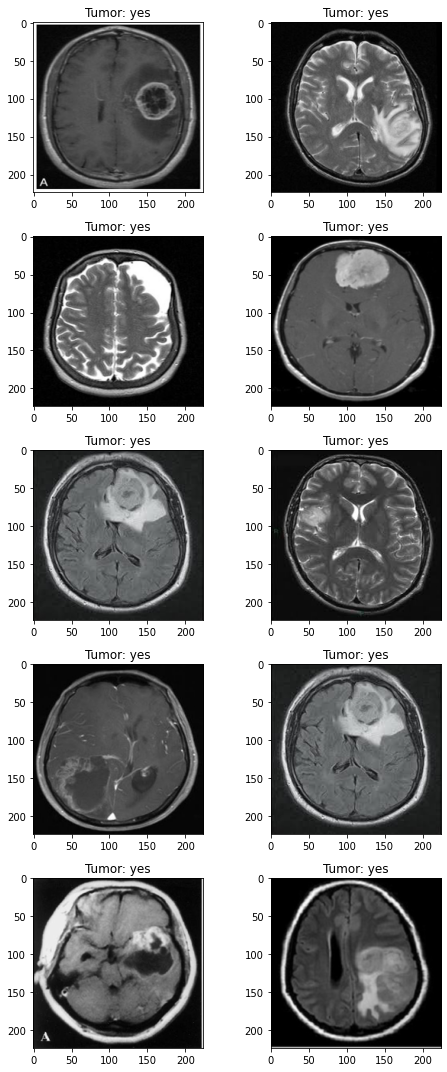

In [10]:
fig,ax = plt.subplots(5,2)

fig.set_size_inches(7,15)

for i in range(5):

    for j in range (2):

        l = np.random.randint(0, len(yes))

        ax[i,j].imshow(X[l])

        ax[i,j].set_title('Tumor: ' + y_labels[l])
        
plt.tight_layout()

## Scans without Tumors

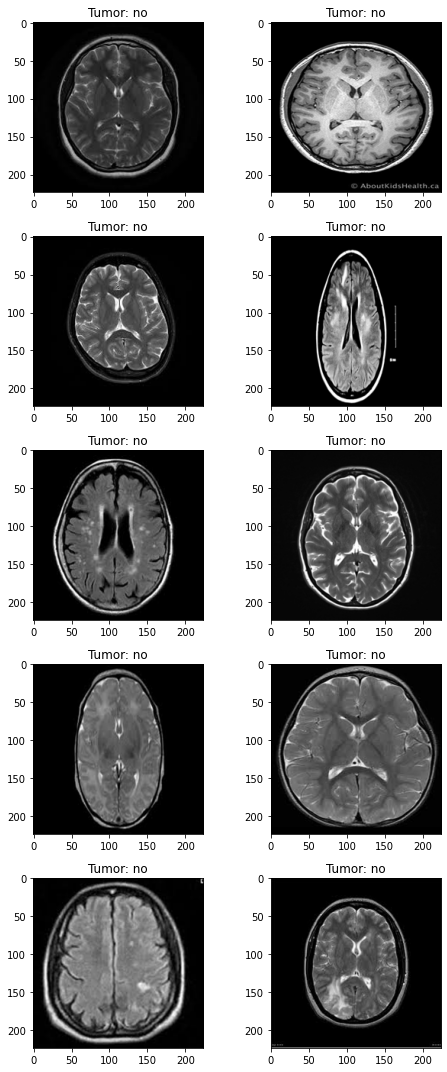

In [11]:
fig,ax = plt.subplots(5,2)

fig.set_size_inches(7,15)

for i in range(5):

    for j in range (2):

        l = np.random.randint(len(yes), len(yes) + len(no))

        ax[i,j].imshow(X[l])

        ax[i,j].set_title('Tumor: ' + y_labels[l])

plt.tight_layout()

## Train Test Split 

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train

,no,yes
38,0,1
143,0,1
84,0,1
55,0,1
217,1,0
...,...,...
106,0,1
14,0,1
92,0,1
179,1,0


In [13]:
# Let's set a baseline plain vanilla network model to use as a baseline for convnet models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import ModelCheckpoint


with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      
      base_model = VGG19(weights='imagenet', include_top=False, input_shape = (224,224,3))

      opt = SGD(lr=.001)

      model = Sequential([base_model])

      model.add(Dropout(0.5))
      model.add(Dense(256,  input_shape=(224, 224, 3), activation='relu'))
      model.add(Dropout(0.5))
      model.add(Flatten())
      model.add(Dense(2, activation='softmax'))


      mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
      red_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.001) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs                                                

      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      model.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test), callbacks=[mc, red_lr])

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 0.8891 - accuracy: 0.5792
Epoch 00001: val_accuracy improved from -inf to 0.70588, saving model to best_model.h5
7/7 [==============================] - 3s 471ms/step - loss: 0.8891 - accuracy: 0.5792 - val_loss: 0.6100 - val_accuracy: 0.7059 - lr: 0.0010
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 0.9022 - accuracy: 0.5248
Epoch 00002: val_accuracy did not improve from 0.70588
7/7 [==============================] - 2s 232ms/step - loss: 0.9022 - accuracy: 0.5248 - val_loss: 0.6069 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 0.9445 - accuracy: 0.5446
Epoch 00003: val_accuracy did not improve from 0.70588

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.001.
7/7 [==============================] - 2s 230ms/step - loss: 0.9445 - accuracy: 0.5446 - val_loss: 0.7711 - val_a

In [14]:
model.history.epoch

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]

In [15]:
# Load libraries for onnx model conversion (keras to onnx)

! pip3 install keras2onnx

! pip3 install onnxruntime

     |████████████████████████████████| 225kB 1.4MB/s 
     |████████████████████████████████| 4.8MB 4.2MB/s 
     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
  Created wheel for fire: filename=fire-0.3.0-py2.py3-none-any.whl size=111108 sha256=7519f3476ace559978e6375e0a0203271b0284550d956bbaaa01b67dea902afb
  Stored in directory: /root/.cache/pip/wheels/92/62/79/6a40acd827ec9d78d610be311820ecf8e41db024d8b1d12ace
Successfully built fire
     |████████████████████████████████| 3.7MB 1.4MB/s 


In [16]:
import os

os.environ['TF_KERAS'] = '1' # Add this environmental variable whenever you use tensorflow's tf.keras to build your keras model

import onnx

import keras2onnx

from keras2onnx import convert_keras

onx = convert_keras(model, 'my_model.onnx')

with open("my_model.onnx", "wb") as f:
  
    f.write(onx.SerializeToString())

Can't import tf2onnx module, so the conversion on a model with any custom/lambda layer will fail!


In [17]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code

  proba = x

  if proba.shape[-1] > 1:

      return proba.argmax(axis=-1)

  else:

      return (proba > 0.5).astype("int32")

raw_predictions = model.predict(X_test)

print(predict_classes(raw_predictions))

prediction_index = predict_classes(raw_predictions)

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels = pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels = list(map(lambda x: labels[x], prediction_index))

print(predicted_labels)

[0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 1
 1 1 0 0 1 0 0 1 1 1 1 0 0 0]
['no', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no']


In [0]:
# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
        
     return finalmetricdata

In [19]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()

y_test_labels = y_test.idxmax(axis=1)

model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.843137,0.842593,0.842593,0.842593,0,0,0,0


In [20]:
# add metrics to submittable object

modelevalobject = model_eval_metrics(y_test_labels, predicted_labels, classification="TRUE")

modelevalobject # add metrics to submittable object

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.843137,0.842593,0.842593,0.842593,0,0,0,0


In [25]:
#install aimodelshare library (version 0.0.3 last updated 3/6/2020)

! pip3 install https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.5.tar.gz?raw=true

  Created wheel for aimodelshare: filename=aimodelshare-0.0.5-cp36-none-any.whl size=5305 sha256=3497eb417d0cda048638f7ad85506adaadf0ccb5e64a64dc6c201c73b5a75927
  Stored in directory: /root/.cache/pip/wheels/ab/28/ae/b9ecb7a3a5542d3f2fed56649fdd6dec1c16f900ef70b93875
Successfully built aimodelshare


In [0]:
# Example Model Pre-launched into Model Share Site

apiurl="https://a53yv0xqce.execute-api.us-east-1.amazonaws.com/prod/m"

username = ""

password = ""

model_filepath = "my_model.onnx"

# New! Assign model object to model argument parameter to submit model architecture to leaderboard.
model = model

# Set aws keys for this project (these keys give you access to collaborate on a single project)

#Importing from object that stores keys so we do not print out keys for others to see.

import pickle

aws_key_password_region = pickle.load(open( "braintumor_modelsubmission_keys.pkl", "rb" ))

aws_key = aws_key_password_region[0]

aws_password = aws_key_password_region[1]

region = aws_key_password_region[2]

In [95]:
# Submit your model using submit_model() function
# Works with models and preprocessors.

import aimodelshare as ai

ai.submit_model(model_filepath=model_filepath, model_eval_metrics=modelevalobject,
                modelobject=model, apiurl=apiurl, username=username, password=password,
                aws_key=aws_key, aws_password=aws_password, region=region, trainingdata="default",
                preprocessor_filepath="default", preprocessor="default")


"my_model.onnx" has been loaded to version 26 of your prediction API.
This version of the model will be used by your prediction api for all future predictions automatically.
If you wish to use an older version of the model, please reference the getting started guide at aimodelshare.com.


In [0]:
# arguments required to get leaderboard below
apiurl="https://a53yv0xqce.execute-api.us-east-1.amazonaws.com/prod/m"

username = ""

password = ""

In [27]:
import aimodelshare as ai

leaderboard = ai.get_leaderboard(apiurl, username, password, aws_key, aws_password, region)

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2,username,model_version,avg_ranking_classification,avg_ranking_regression,model_config,model_optim_config,model_epochs
15,0.941176,0.940812,0.942547,0.939815,0,0,0,0,Taketo,17,1.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
14,0.901961,0.901354,0.902950,0.900463,0,0,0,0,Taketo,16,2.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",10
16,0.875000,0.868718,0.868718,0.868718,0,0,0,0,3scman,18,3.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.01, 'decay...",25
21,0.862745,0.862745,0.865741,0.865741,0,0,0,0,dhoward97,24,4.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 1.5625e-05, ...",25
23,0.862745,0.862534,0.862308,0.863426,0,0,0,0,seanmcalevey,26,5.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",50
17,0.823529,0.813187,0.875000,0.812500,0,0,0,0,AlisaAi,19,5.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",25
20,0.843137,0.841615,0.845611,0.840278,0,0,0,0,seanmcalevey,23,6.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",25
13,0.803922,0.802019,0.805643,0.800926,0,0,0,0,Taketo,15,8.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
12,0.784314,0.778873,0.796053,0.777778,0,0,0,0,SUN-Wenjun,14,9.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",20
3,0.784314,0.775690,0.808824,0.775463,0,0,0,0,username1,5,9.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5


In [43]:
# Import and print model details from leaderboard

model_config = leaderboard.loc[0, 'model_config'] # model details best model (i.e.-row #1)

model_optim_config = leaderboard.loc[0, 'model_optim_config'] # model details best model (i.e.-row #1)

print(model_config)

print(model_optim_config)

backend: tensorflow
class_name: Sequential
config:
  layers:
  - class_name: Dense
    config:
      activation: relu
      activity_regularizer: null
      batch_input_shape: !!python/tuple [null, 224, 224, 3]
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {dtype: float32}
      bias_regularizer: null
      dtype: float32
      kernel_constraint: null
      kernel_initializer:
        class_name: GlorotUniform
        config: {dtype: float32, seed: null}
      kernel_regularizer: null
      name: dense
      trainable: true
      units: 64
      use_bias: true
  - class_name: Dense
    config:
      activation: relu
      activity_regularizer: null
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {dtype: float32}
      bias_regularizer: null
      dtype: float32
      kernel_constraint: null
      kernel_initializer:
        class_name: GlorotUniform
        config: {dtype: float32, seed: null}

## Best Model Summary

In [65]:
# Import model config to use to fit same architecture to new data

from tensorflow.keras.models import model_from_yaml

model = model_from_yaml(model_config)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 224, 224, 64)      256       
_________________________________________________________________
dense_1 (Dense)              (None, 224, 224, 64)      4160      
_________________________________________________________________
dense_2 (Dense)              (None, 224, 224, 64)      4160      
_________________________________________________________________
flatten (Flatten)            (None, 3211264)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6422530   
Total params: 6,431,106
Trainable params: 6,431,106
Non-trainable params: 0
_________________________________________________________________


In [69]:
optimizer = SGD(lr=0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test), callbacks=[mc, red_lr])

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 0.6424 - accuracy: 0.6337
Epoch 00001: val_accuracy did not improve from 0.86275
7/7 [==============================] - 1s 143ms/step - loss: 0.6424 - accuracy: 0.6337 - val_loss: 0.6542 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 0.6019 - accuracy: 0.6386
Epoch 00002: val_accuracy did not improve from 0.86275
7/7 [==============================] - 1s 126ms/step - loss: 0.6019 - accuracy: 0.6386 - val_loss: 0.6222 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 0.5764 - accuracy: 0.6287
Epoch 00003: val_accuracy did not improve from 0.86275

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.001.
7/7 [==============================] - 1s 127ms/step - loss: 0.5764 - accuracy: 0.6287 - val_loss: 0.6516 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 4/50
7/7 [==============================] - ETA: 0s - loss: 0.

In [71]:
print('Score on test set:', model.evaluate(X_test, y_test))

2/2 [==============================] - 0s 24ms/step - loss: 0.4589 - accuracy: 0.7843
Score on test set: [0.458940327167511, 0.7843137383460999]


Write Up:

It's critically important for the medical community to be able to classify whether or not radiological scans of the brain contain tumors. If there are machine learning models that are more accurate on average than their human counterparts, that would be a boon to the medical community since it would save signficant time and human labor, while also improving the accuracy of classification.

As you will see above, the first model I submitted was a simple feed-forward neural net with no dropout that had an accuracy of 72.5%, an F1 score of	0.706414, a precision of 0.766409, and a recall of 0.712963. It did fairly well considering its lack of sophistication but the scores could certainly be improved.

The second model I submitted was a feed-forward neural net with 0.5 dropout before each layer, meaning 50% of the inputs to each layer were randomly dropped, which helps regularize the model during training. The model had an accuracy of 86.3%, an F1 score of	0.86253, a precision of 0.862308, and a recall of 0.863426. These scores were very impressive, not least because it was trained for longer with heavier dropout, meaning it resisted overfitting better than the previous model while also training for a longer period of time.

The third model imported VGG19 as its initial set of layers, and then added a layer of 256 neurons with 50% dropout before outputting a dense layer of two neurons like the other models. This model had an accuracy of 84.3%, an F1 score of	0.841615, a precision of 0.845611, and a recall of	0.840278. Surprisingly this model scored slightly worse overall than the previous model, but nonetheless still scored 6th overall on the leaderboard in terms of accuracy. Clearly the imported VGG19 layers did a good job of bootstrapping the weights into an intially effective structure for understanding visual data such as the radiological scans in the exercise.

The best model from the leaderboard had a structure of three dense layers of 64 units each that are flattened into a nearly 3M dimensional vector and then connected to a softmax layer of that outputs a probability for each class. The surprising thing was that this model didn't use the dropout regularization of my best model but it still outperformed it significantly. But the model is relatively simple: it just uses three 64 unit layers and a softmax output to achieve its result. On the other hand my best model had an initial layer of 256 and then two 64 unit layers before its softmax output; it also had 50% dropout between each layer, which as noted above worked to counteract overfitting. 

Also notable was that the optimization approach of the best model from the leaderboard was the same as my best model: both used standard stochastic gradient descent with a 0.001 learning rate without momentum. A different approach might use an optimizer like 'adam' or 'rmsprop', but seeing as the best model used simple stochastic gradient descent, perhaps the best approach is to keep optimization simple and not stray far from SGD without momentum. Nonetheless, my model's similarly simplistic approach (with dropout regularization, however) did not outperform the best model on the leaderboard.

Finally as you'll notice, I fit the best model's architecture to the training data and then scored it on the testing set. It scored a 78.4% accuracy on the test set, which was lower than the leaderboard score. This isn't surprising, however, since for small datasets a lot of the final testing score depends on how the data was split into train and test sets, as some test set combinations may be easier to classify than others.